# Image Processing Concepts

Simple examples of image processing concepts on OpenCV. Concepts explored:

### Object Detection###

Feature Keypoints & Descriptors

* <b>ORB (Oriented FAST and Rotated BRIEF)</b>
* SIFT (Scale-Invariant Feature Transform) 
* SURF (Speeded-Up Robust Features)
* BRIEF (Binary Robust Independent Elementary Features)

Feature Matching, Object Detection using Homography & perspective transformation
* <b>Brute-Force matcher</b>
* FLANN (Fast Library for Approximate Nearest Neighbors)


In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pylab import rcParams
rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0
rcParams['figure.figsize'] = (14,6)


## Overview

ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance. 

<b>Keypoint detector</b> is an algorithm that <b>chooses points from an image based on some criterion</b>. Typically, an interest point is a local maximum of some function, such as a "cornerness" metric.

A <b>descriptor</b> is a vector of values, which somehow <b>describes the image patch around an interest point</b>. It could be as simple as the raw pixel values, or it could be more complicated, such as a histogram of gradient orientations.

First it use <b>FAST to find keypoints</b>, then apply Harris corner measure to find top N points among them. It also use pyramid to produce multiscale-features. But one problem is that, FAST doesn’t compute the orientation. So what about rotation invariance? Authors came up with following modification.

It computes the intensity weighted centroid of the patch with located corner at center. The direction of the vector from this corner point to centroid gives the orientation. To improve the rotation invariance, moments are computed with x and y which should be in a circular region of radius r, where r is the size of the patch.

Now for descriptors, ORB use <b>BRIEF descriptors</b>. But we have already seen that BRIEF performs poorly with rotation. So what ORB does is to “steer” BRIEF according to the orientation of keypoints. 

BRIEF has an important property that each bit feature has a large variance and a mean near 0.5. But once it is oriented along keypoint direction, it loses this property and become more distributed. High variance makes a feature more discriminative, since it responds differentially to inputs. Another desirable property is to have the tests uncorrelated, since then each test will contribute to the result. To resolve all these, ORB runs a greedy search among all possible binary tests to find the ones that have both high variance and means close to 0.5, as well as being uncorrelated. The result is called rBRIEF.

For descriptor matching, multi-probe LSH which improves on the traditional LSH, is used. The paper says ORB is much faster than SURF and SIFT and ORB descriptor works better than SURF. <b>ORB is a good choice in low-power devices</b> for panorama stitching etc.


### ORB Feature Detection

We have to create an ORB object with the function, cv2.ORB() or using feature2d common interface. 

It has a number of optional parameters. Most useful ones are nFeatures which denotes maximum number of features to be retained (by default 500), scoreType which denotes whether Harris score or FAST score to rank the features (by default, Harris score) etc. Another parameter, WTA_K decides number of points that produce each element of the oriented BRIEF descriptor. By default it is two, ie selects two points at a time. In that case, for matching, NORM_HAMMING distance is used. If WTA_K is 3 or 4, which takes 3 or 4 points to produce BRIEF descriptor, then matching distance is defined by NORM_HAMMING2.

(<matplotlib.axes._subplots.AxesSubplot at 0x2b5dd37da20>,
 Text(0.5, 1.0, 'ORB Features'),
 (-0.5, 2319.5, 1739.5, -0.5))

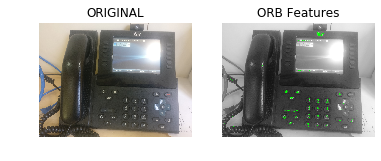

In [4]:
#Train Image
img_t = cv2.imread('images/train.jpg')
img_t= cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB)
img1_t = cv2.cvtColor(img_t, cv2.COLOR_RGB2GRAY)

# Initiate STAR detector
orb_t = cv2.ORB_create(nfeatures=1500)

# find the keypoints with ORB
kp_t = orb_t.detect(img1_t,None)

# compute the descriptors with ORB
kp_t, des_t = orb_t.compute(img1_t, kp_t)

# draw only keypoints location,not size and orientation
img2_t = cv2.drawKeypoints(img1_t,kp_t,None,color=(0,255,0), flags=0)

plt.subplot(121),plt.imshow(img_t),plt.title('ORIGINAL'),plt.axis("Off")
plt.subplot(122),plt.imshow(img2_t),plt.title('ORB Features'),plt.axis("off")

(<matplotlib.axes._subplots.AxesSubplot at 0x2b5e3a02048>,
 Text(0.5, 1.0, 'ORB Features'),
 (-0.5, 4639.5, 3479.5, -0.5))

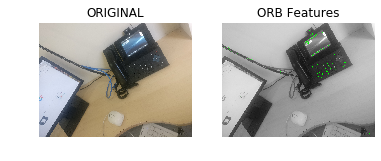

In [5]:
#Query Image
img_q = cv2.imread('images/query.jpg')
img_q = cv2.cvtColor(img_q, cv2.COLOR_BGR2RGB)
img1_q = cv2.cvtColor(img_q, cv2.COLOR_RGB2GRAY)

# Initiate STAR detector
orb_q = cv2.ORB_create(nfeatures=5000)

# find the keypoints with ORB
kp_q = orb_q.detect(img1_q,None)

# compute the descriptors with ORB
kp_q, des_q = orb_q.compute(img1_q, kp_q)

# draw only keypoints location,not size and orientation
img2_q = cv2.drawKeypoints(img1_q,kp_q,None,color=(0,255,0), flags=0)

plt.subplot(121),plt.imshow(img_q),plt.title('ORIGINAL'),plt.axis("Off")
plt.subplot(122),plt.imshow(img2_q),plt.title('ORB Features'),plt.axis("off")

### ORB Feature Matching

#### Brute Force Matching
Brute-Force matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some <b>distance calculation</b>. And the closest one is returned.

For BF matcher, first we have to create the BFMatcher object using cv2.BFMatcher(). It takes two optional params. First one is normType. It specifies the distance measurement to be used. By default, it is cv2.NORM_L2. It is good for SIFT, SURF etc (cv2.NORM_L1 is also there). For binary string based descriptors like ORB, BRIEF, BRISK etc, cv2.NORM_HAMMING should be used, which used Hamming distance as measurement. If ORB is using WTA_K == 3 or 4, cv2.NORM_HAMMING2 should be used.

Second param is boolean variable, crossCheck which is false by default. If it is true, Matcher returns only those matches with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match and vice-versa. That is, the two features in both sets should match each other. It provides consistant result, and is a good alternative to ratio test proposed by D.Lowe in SIFT paper.

Once it is created, two important methods are <b>BFMatcher.match()</b> and <b>BFMatcher.knnMatch()</b>. First one returns the best match. Second method returns k best matches where k is specified by the user. It may be useful when we need to do additional work on that.

#### FLANN based Matcher
FLANN stands for Fast Library for Approximate Nearest Neighbors. It contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features. It works more faster than BFMatcher for large datasets. We will see the second example with FLANN based matcher.

(<matplotlib.axes._subplots.AxesSubplot at 0x2b5f032f390>,
 Text(0.5, 1.0, 'ORB-Feature-Matching'),
 (-0.5, 6959.5, 3479.5, -0.5))

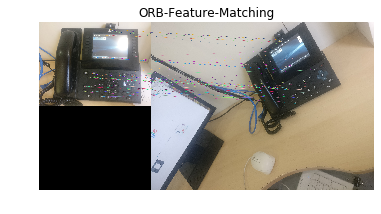

In [6]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des_t,des_q, k=2)

# Apply ratio test
good = []
good_matches= []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)
        good_matches.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img_t,kp_t,img_q,kp_q,good_matches,None,flags=2)

plt.subplot(111),plt.imshow(img3),plt.title('ORB-Feature-Matching'),plt.axis("Off")

### Object detection using homography

We found locations of some parts of an object in another cluttered image. This information is sufficient to find the object exactly on the trainImage.

For that, we can use a function from calib3d module, ie <b>cv2.findHomography()</b>. If we pass the set of points from both the images, it will find the perpective transformation of that object. Then we can use <b>cv2.perspectiveTransform()</b> to find the object. It needs atleast four correct points to find the transformation.

We have seen that there can be some possible errors while matching which may affect the result. To solve this problem, algorithm uses <b>RANSAC</b> or LEAST_MEDIAN (which can be decided by the flags). So good matches which provide correct estimation are called inliers and remaining are called outliers. cv2.findHomography() returns a mask which specifies the inlier and outlier points.

So let’s do it !!!



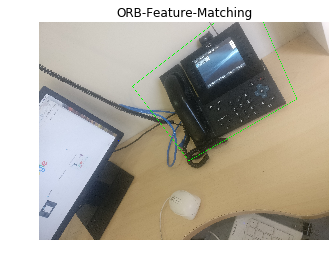

In [7]:
MIN_MATCH_COUNT = 20


if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_t[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_q[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img_t.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img_q = cv2.polylines(img_q,[np.int32(dst)],True,(0,255,0),5, cv2.LINE_AA)
    
    plt.subplot(111),plt.imshow(img_q),plt.title('ORB-Feature-Matching'),plt.axis("Off")

else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

In [13]:
print('The end!')

The end!
